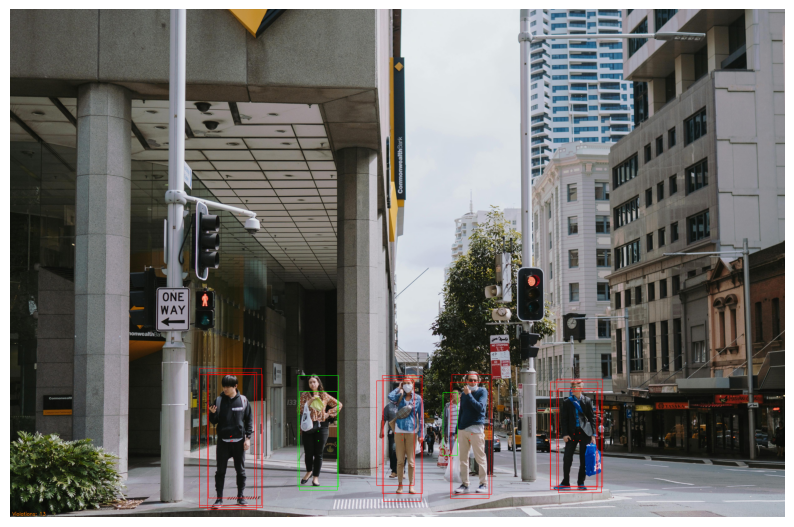

In [23]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load YOLOv3 model
net = cv2.dnn.readNet("yolov3.weights", "yolov3.cfg")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

# Distance threshold for social distancing
distance_thres = 50

# Load COCO class labels
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Load the image
img_path = '/content/pexels-katetrifo-4019405.jpg'
img = cv2.imread(img_path)
if img is None:
    print("Error: Could not load image. Check the file path.")
else:
    height, width = img.shape[:2]

    # Define output layers for YOLO
    layer_names = net.getLayerNames()
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

    # Helper function to calculate distance
    def dist(pt1, pt2):
        return ((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)**0.5

    # Pre-process the image for YOLO
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    confidences = []
    boxes = []
    persons = []
    person_centres = []
    violate = set()

    # Analyze detections
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            if class_id != 0:  # Class 0 is 'person' in COCO dataset
                continue
            confidence = scores[class_id]
            if confidence > 0.3:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                persons.append([x, y, w, h])
                person_centres.append([center_x, center_y])

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    # Check social distancing
    for i in range(len(persons)):
        for j in range(i + 1, len(persons)):
            if dist(person_centres[i], person_centres[j]) <= distance_thres:
                violate.add(tuple(persons[i]))
                violate.add(tuple(persons[j]))

    v = 0  # Count of violations
    for (x, y, w, h) in persons:
        color = (0, 255, 0)  # Green for safe distancing
        if (x, y, w, h) in violate:
            color = (0, 0, 255)  # Red for violation
            v += 1
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.circle(img, (x + w // 2, y + h // 2), 2, color, 2)

    # Display violation count
    cv2.putText(img, f'Violations: {v}', (15, height - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 126, 255), 2)

    # Convert BGR to RGB for displaying with Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the final output
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')  # Hide the axes
    plt.show()
